# CS4305TU: Week 6 - Artificial Neural Network - Assignment
## Investigating neighbourhood choice behaviour using ANNs
**7 & 11 October 2021**

- Sander van Cranenburgh
- Francisco Garrido-Valenzuela 

### General information

* For this assignment we will use *Stated Choice data* on residential location choice, collected in:
    - Mainz, Germany
    - Hanover, Germany
    - Bern, Switzerland
    - Zurich, Switzerland 

- For more details on the data, see the description provided on [Brightspace](https://brightspace.tudelft.nl/d2l/le/content/399675/viewContent/2506146/View). 

- In total you can earn **6.0** points in this assignment. 

- Add **Code cells** to complement your analyses. You can draw a lot form the snippets of codes we used for the in-class exercises.

### Submission instructions

- Answer the questions (code and/or text) in this notebook
- Rename this file by adding your group nomber (e.g. Assignment_groupXX.ipynb)
- Submit your answers both in ipynb and html format

**Provide your answers in the allocated markdown boxes** (with the red font color)


### Set up your environment

You need to set up your environment based on which platform you would like to use. In this case we offer two options:

- Google Colaboratory (Colab)
- Jupyter Lab or Notebooks (Local)

#### Using Colab

Students using **Colab**, just need to install **Biogeme**. Biogeme is a Python package designed for the maximum likelihood estimation of parametric models in general, with a special emphasis on discrete choice models. Just run the following notebook cell:

In [1]:
# Uncomment and run this cell if you are using Google Colab (keep the exclamation mark)
#!pip install biogeme
#!git clone https://github.com/cs4305tu/assignment
#root = 'assignment/'

#### Using local environment

Students using their *local environments*, need to install all the dependencies used in this *Week 6*, to ensure compatibility, they also need to check the versions of each dependency. All dependencies are contained in the text file: **requirements.txt**. Just run the following notebook cell:

In [2]:
# Uncomment and run this cell if you are using your local environment (keep the exclamation mark)
# !pip3 install -r requirements.txt
# root = ''

### Required Python packages

In the following cell add all the packages you need to finish this assignment.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from heatmap import corrplot
import biogeme.biogeme as bio
import biogeme.database as db
import biogeme.optimization as opt
import biogeme.messaging as msg
from biogeme import models
from biogeme.expressions import Beta

import tensorflow as tf
print("Using tensorflow ",tf.__version__)
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Dense, Activation
from keras.layers import Conv2D, Add, Reshape
from keras.models import Model
from keras.utils.np_utils import to_categorical   
import matplotlib.pyplot as plt
import numpy as np

# Import ML packaged and modules
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, log_loss

Using tensorflow  2.6.0


### Opening the database

In [4]:
# Load the data into a dataframe
root = ''
df_raw = pd.read_csv(f'{root}datasets/neighbourhood_choice2018.dat', sep='\t')
df_raw.head()

,ID,ID2,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,...,NOISE3,GREEN3,FOREIGN3,CHOICE,SSTADT,RESPCITY,WOMAN,AGE,ENVCONC,COMPLETE
0,2,5,10,5,1,2,2,0.4,15,10,...,4,4,0.2,1,3,3,0,42,3.0,1
1,2,6,15,5,4,4,1,0.1,2,10,...,2,3,0.3,2,3,3,0,42,3.0,1
2,2,7,10,15,1,3,1,0.4,15,2,...,1,3,0.2,3,3,3,0,42,3.0,1
3,2,8,15,15,5,4,4,0.4,2,2,...,2,2,0.2,2,3,3,0,42,3.0,1
4,3,9,15,5,5,1,3,0.4,2,10,...,3,1,0.2,2,2,2,1,41,4.5,1


## Questions

### Q1. Do a proper descriptive analysis of the data set (1.0 pt)

It is good practice to do a descriptive analysis of the data you want to model, prior to the real modelling. So inspect e.g. what levels the attributes (features) take, correlations, class (im)balances, redudant variables, missing values, etc. to attain a good feeling for the data.

In [5]:
# All features in dataset, devided into the choice feature, and additional feaures.
features_choices = ['STORES', 'TRANSPORT', 'CITY', 'NOISE', 'GREEN', 'FOREIGN']
features_other = ['WOMAN', 'AGE', 'SSTADT', 'RESPCITY', 'ENVCONC']
print(f'The choice features are: {features_choices}')
print(f'Other available features are: {features_other}')
print(f"The evaluation metric is ['CHOICE']")

# Check for Nan values in dataset
print(f'\nTotal number of Nan values: {df_raw.isna().sum().sum()}')
# Check for empty (None) values in dataset
print(f'Total number of empty (None) values: {int(df_raw[df_raw==None].sum().sum())}')
# Check for complete responses
print(f'Total number of incomplete responses: {df_raw.COMPLETE[df_raw.COMPLETE==0].sum()}')

# Check the various levels that each feature can take
print('\nCheck the levels that each feature can take:')
print('Choice features:')
for feature in features_choices:
    feature_choice = [feature+str(choice) for choice in range(1, 4)]
    levels = np.unique(df_raw[feature_choice].to_numpy().flatten())
    print(f"\t{feature} can take: {levels}")
print('Other features')
for feature in features_other:
    levels = np.unique(df_raw[feature].to_numpy().flatten())
    print(f"\t{feature} can take: {levels}")

# Check for faulty values
print(f'\nTotal number of 99999 values in AGE: {df_raw.AGE[df_raw.AGE==99999].size}')
print(f'Total number of 99999 values in WOMAN: {df_raw.WOMAN[df_raw.WOMAN==99999].size}')
print(f'Total number of 9.99990000e+04 values in ENVCONC: {df_raw.ENVCONC[df_raw.ENVCONC==9.99990000e+04].size}')
# Remove faulty values
df = df_raw[(df_raw.WOMAN != 99999) & (df_raw.AGE != 99999) & (df_raw.ENVCONC != 99990000e+04)]
print(f'\nRows containing faulty values are removed in "df"')

# Remove irrelevant features
df = df.drop(['ID', 'ID2', 'COMPLETE'], axis=1)


The choice features are: ['STORES', 'TRANSPORT', 'CITY', 'NOISE', 'GREEN', 'FOREIGN']
Other available features are: ['WOMAN', 'AGE', 'SSTADT', 'RESPCITY', 'ENVCONC']
The evaluation metric is ['CHOICE']

Total number of Nan values: 0
Total number of empty (None) values: 0
Total number of incomplete responses: 0

Check the levels that each feature can take:
Choice features:
	STORES can take: [ 2  5 10 15]
	TRANSPORT can take: [ 2  5 10 15]
	CITY can take: [1 2 4 5]
	NOISE can take: [1 2 3 4]
	GREEN can take: [1 2 3 4]
	FOREIGN can take: [0.1 0.2 0.3 0.4]
Other features
	WOMAN can take: [    0     1 99999]
	AGE can take: [   18    19    20    21    22    23    24    25    26    27    28    29
    30    31    32    33    34    35    36    37    38    39    40    41
    42    43    44    45    46    47    48    49    50    51    52    53
    54    55    56    57    58    59    60    61    62    63    64    65
    66    67    68    69    70 99999]
	SSTADT can take: [1 2 3 4]
	RESPCITY can ta

Total number of choices: 9656
--------------------------------
	 Number of choices equal to 1: 3419 --> 35.41% of total
	 Number of choices equal to 2: 3246 --> 33.62% of total
	 Number of choices equal to 3: 2991 --> 30.98% of total


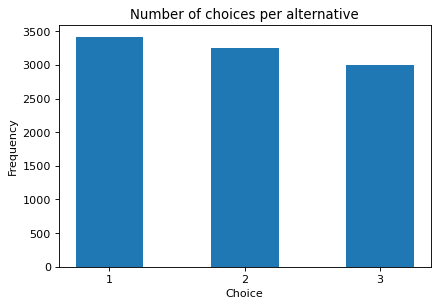

In [6]:
# Show how often each alternative is chosen
print(f"Total number of choices: {len(df.CHOICE)}")
print('--------------------------------')
for choice in range(1, 4):
    print(f"\t Number of choices equal to {choice}: {len(df.CHOICE[df.CHOICE == choice])} --> {round(len(df.CHOICE[df.CHOICE == choice])/len(df.CHOICE)*100, 2)}% of total")

fig=plt.figure(figsize=(6,4), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(df.CHOICE, bins = [0.75, 1.25, 1.75, 2.25, 2.75, 3.25])
plt.xticks((1, 2, 3))
plt.title('Number of choices per alternative')
plt.xlabel('Choice')
plt.ylabel('Frequency')
plt.show()

Correlation of each feature to CHOICE, sorted by absolute value:
CHOICE        1.000000
GREEN1        0.269395
NOISE1        0.235075
GREEN3        0.222014
NOISE3        0.217443
TRANSPORT1    0.196445
TRANSPORT3    0.187104
NOISE2        0.168003
CITY3         0.165390
CITY1         0.154733
TRANSPORT2    0.094403
FOREIGN1      0.094172
STORES3       0.079956
CITY2         0.068386
FOREIGN3      0.062488
STORES1       0.059513
FOREIGN2      0.049579
GREEN2        0.025982
AGE           0.014812
WOMAN         0.011703
SSTADT        0.010152
RESPCITY      0.010152
ENVCONC       0.004726
STORES2       0.000912
Name: CHOICE, dtype: float64


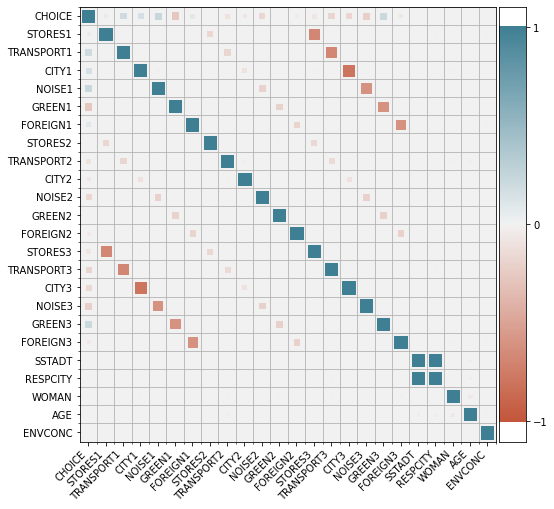

In [7]:
# Obtain correlations
all_features = list(df.columns[df.columns!='CHOICE'])

# get choice as first input
corr = df[['CHOICE'] + all_features].corr()
corr_choice = corr['CHOICE']
abs_corr_sorted = corr_choice.abs().sort_values(ascending=False)     # sorted by largest correlation to income

print('Correlation of each feature to CHOICE, sorted by absolute value:')
print(abs_corr_sorted)

plt.figure(figsize=(8, 8))
corrplot(corr, size_scale=150)

In [8]:
# Remove additional attributes
df_reduced = df.drop(features_other, axis=1)
print(f'Final reduced dataframe "df_reduced" of shape {df_reduced.shape}:')
display(df_reduced.head())

# Remove irrelevant labels
df = df.drop(['RESPCITY'], axis=1)
print(f'Final complete dataframe "df" of shape {df.shape}:')
display(df.head())


Final reduced dataframe "df_reduced" of shape (9656, 19):


,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,CITY2,NOISE2,GREEN2,FOREIGN2,STORES3,TRANSPORT3,CITY3,NOISE3,GREEN3,FOREIGN3,CHOICE
0,10,5,1,2,2,0.4,15,10,2,3,3,0.1,2,15,4,4,4,0.2,1
1,15,5,4,4,1,0.1,2,10,5,1,2,0.2,5,15,1,2,3,0.3,2
2,10,15,1,3,1,0.4,15,2,2,4,2,0.1,2,5,4,1,3,0.2,3
3,15,15,5,4,4,0.4,2,2,1,1,1,0.1,5,5,2,2,2,0.2,2
4,15,5,5,1,3,0.4,2,10,1,2,4,0.1,5,15,2,3,1,0.2,2


Final complete dataframe "df" of shape (9656, 23):


,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,CITY2,NOISE2,...,TRANSPORT3,CITY3,NOISE3,GREEN3,FOREIGN3,CHOICE,SSTADT,WOMAN,AGE,ENVCONC
0,10,5,1,2,2,0.4,15,10,2,3,...,15,4,4,4,0.2,1,3,0,42,3.0
1,15,5,4,4,1,0.1,2,10,5,1,...,15,1,2,3,0.3,2,3,0,42,3.0
2,10,15,1,3,1,0.4,15,2,2,4,...,5,4,1,3,0.2,3,3,0,42,3.0
3,15,15,5,4,4,0.4,2,2,1,1,...,5,2,2,2,0.2,2,3,0,42,3.0
4,15,5,5,1,3,0.4,2,10,1,2,...,15,2,3,1,0.2,2,2,1,41,4.5


<font color='red'>

**ANSWER Q1** <br>
The dataset is seen to consist out of two main set of features. The first set is the various 'choice features' available for each of the three choices; and the second set consist of 'other features', which contain information regarding the applicant, e.g.: age, woman (yes or no), place of citizenship.

Considering all the available data, the dataset is checked for Nan and empty values. It is found that none of these input types are present. It is also checked whether all choices are complete, which is done by evaluation the COMPLETE feature. This is also found to be true for all choices. Furthermore, the features ID, ID2, and COMPLETE are removed as they are not used any further in this assignment.

Then, the type of levels each feature can take-on are obtained. For the choice features, no irrelevant/faulty levels are seen to exist in the dataset. For the 'other features', it can be seen that WOMAN, AGE, and ENVCONC, contain irrelevant/faulty levels, equal to 99999. The number of occurances of these irrelevant levels are obtained for the three features. As this turns out to be a relatively low number, the rows containing faulty values are removed.

Furthermore, the data is seen to be nicely balanced, with a distribution of 35.41%, 33.62%, and 30.98%, for the three choices, respectively.

Finally, the correlations for all features to the CHOICE are constructed. These correlations are plotted, from which it can be seen that the 'other features' (AGE, WOMAN, SSTADT, RESPCITY, ENVCONC) and STORES2 have a low correlation to the CHOICE. Since the DCM does not use the 'other features', no features have to be removed. The ANN does use all features, including the low-correlated features. As the ANN is able to capture more complex relations it is still found useful to use all features.

Furthermore, the correlation plot shows that SSTADT and RESPCITY are the same feature, correlated with 1. RESPCITY can therefore be removed from the dataset.

### Q2. Estimate a RUM-MNL discrete choice model (1.0 pt)

Assume utility is linear additive-utility: 

$ V_{in} = \sum_{m}\beta_m x_{imn}$

And estimate marginal utilities (i.e. betas) for: 

1. Distance to Transport [min] (**Note** that distances are given in minutes)
2. Distance to City [km]
3. Distance to Stores [min] (**Note** that distances are given in minutes)
4. Traffic Noise
5. Green area
6. Share of foreigners [%]

**Note:** Do not add any other variables (features) to the model.

**To get the scores, address the following:**

- (A) Report the parameter estimates, and interpret them. i.e. do they have the expected sign? (0.5 pts)
- (B) Compute and report the cross-entropy (0.5 pts)

In [9]:
# Create a DataFrame with pandas and database variable for Biogeme estimation
database = db.Database('residential_choicedata2021', df_reduced)

# The following statement allows you to use the names of the variable stored in Biogeme as Python variables.
globals().update(database.variables)

In [10]:
B_stores = Beta('B_stores', 0, None, None, 0)
B_transport = Beta('B_transport', 0, None, None, 0)
B_city = Beta('B_city', 0, None, None, 0)
B_noise = Beta('B_noise', 0, None, None, 0)
B_green = Beta('B_green', 0, None, None, 0)
B_foreign = Beta('B_foreign', 0, None, None, 0)

In [11]:
# Utility functions
V1 = B_stores * STORES1 + B_transport * TRANSPORT1 + B_city * CITY1 + B_noise * NOISE1 + B_green * GREEN1 + B_foreign * FOREIGN1
V2 = B_stores * STORES2 + B_transport * TRANSPORT2 + B_city * CITY2 + B_noise * NOISE2 + B_green * GREEN2 + B_foreign * FOREIGN2
V3 = B_stores * STORES3 + B_transport * TRANSPORT3 + B_city * CITY3 + B_noise * NOISE3 + B_green * GREEN3 + B_foreign * FOREIGN3

In [12]:
# Associate utility functions with the numbering of alternatives in df.CHOICE
V = {1: V1, 2: V2, 3: V3}

# Associate the availability conditions with the alternatives
av = {1:1, 2:1, 3:1}

In [13]:
# Definition of the model. This is the contribution of each observation to the log likelihood function.
prob = models.loglogit(V, av, CHOICE)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, prob)
biogeme.modelName = 'My first discrete choice model'
biogeme.generatePickle = False
biogeme.generateHtml = False

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters
results1 = biogeme.estimate()

# Report the results in a pandas table
print('Estimated parameters')
print('----------')
pandasResults = results1.getEstimatedParameters()
print(pandasResults[['Value','Std err','t-test','p-value']])


Estimated parameters
----------
                Value   Std err     t-test  p-value
B_city      -0.168094  0.007977 -21.072663      0.0
B_foreign   -1.173841  0.109769 -10.693729      0.0
B_green      0.416031  0.011653  35.701378      0.0
B_noise     -0.438004  0.011379 -38.490741      0.0
B_stores    -0.034612  0.002586 -13.386340      0.0
B_transport -0.073980  0.002556 -28.944421      0.0


In [14]:
from sklearn.metrics import log_loss

# Get the estimated betas from the discrete choice model
betas1 = results1.getBetaValues()

# Define compute objects
prob_1 = models.logit(V, av, 1)
prob_2 = models.logit(V, av, 2)
prob_3 = models.logit(V, av, 3)

# Define dictionary
simulate_dict = {
    'Prob_1': prob_1,
    'Prob_2': prob_2,
    'Prob_3': prob_3}

# Create Biogeme object
simulator = bio.BIOGEME(database, simulate_dict)

# Compute probabilities using the estimated choice model
probs_DCM = simulator.simulate(betas1)

# Compute the cross-entropy for the DCM
cross_entropy_DCM = log_loss(df_reduced.CHOICE, probs_DCM)

print('The cross-entropy of the DCM is        ',"{:.3f}".format(cross_entropy_DCM))


The cross-entropy of the DCM is         0.889


<font color='red'>

**ANSWER Q2** <br>
The signs make sense as people in general want to be close to things as the city, stores and transport. Also they want less foreigners in their neighbourhood and less noise from traffic. They do want more green in their neighboorhood. 
We can see that people attach most value to not having a lot of foreigners close to their home and less to the other properties. After that green and noise are most important. 
    
<br> The cross-entropy measures the performance of a classification model. The cross-entropy increases as the predicted probability diverges from the actual label. A perfect model would have a cross-entropy of 0, so minimization of the cross-entropy leads to optimization of the model. In the situation above we have found a cross-entropy of 0.889, which is high.

### Q3. Based on your results, compute the WtP of the average decision maker to reduce the share of foreigners in a neighbourhood by 1 percentage point in terms of the distance to the grocery stores (0.5 pts)

Thus, the answer must be of the following form: .... [minutes/percentage point].


In [15]:
## Wtp for less foreigners in a neighbourhood compared to distance to grocery stores. So B_foreign/B_stores
# Get the results in a pandas table
print('Willingness-to-Pay estimates')
print('----------')
WtP_foreign_stores = betas1['B_foreign']/betas1['B_stores']

print('Willingness to Pay; reduction in foreigners at an expense of store distance = ', "{:.2f}".format(WtP_foreign_stores),'min per percentage point')

Willingness-to-Pay estimates
----------
Willingness to Pay; reduction in foreigners at an expense of store distance =  33.91 min per percentage point


<font color='red'>

**ANSWER Q3** <br>
We could see from the beta-values already that people don't attach a lot of value to a short distance towards grocery stores (beta = -0.034432), while they do think a lower percentage of foreigners is important (beta = -1.195431). We can see from the Willingness-to-pay that for every percentage of less foreigners, people are willing to add 34.7 min to the walking distance towards the nearest grocery store. 

### Q4. Train a hybrid RUM-MNL-ANN model (1.5 pts)

Since we are interested in the WtP of Q3, make sure when building the hybrid model to place the features of the share of foreigners and of the distance to the grocery stores in the *MNL part of the model*. For the *ANN part of the model* use 2 hidden layers, with 5 nodes each. 


**To get the scores, address the following:**


- (A) Build the model, plot the loss as a function of the epochs & report the cross entropy of your final model based on the test data. (1.0 pt)
- (B) Compare the model performance to that of the discrete choice model. Interpret the result. (0.5 pts)

In [16]:
def hybrid_RUM_MNL_ANN_model(NALT, no_X_MNL, no_X_ANN, num_nodes, seed=None):
    tf.random.set_seed(seed)
    
    #######################
    ### DEFINE MNL PART ###
    #######################
    # INPUT FOR MNL PART
    X_MNL = Input((no_X_MNL, NALT, 1), name = 'Features2MNL')

    # COMPUTE UTILITY FOR MNL
    V_MNL = Conv2D(filters = 1, kernel_size = [no_X_MNL,1], strides = (1,1), padding = 'valid', name = 'MNL_layer', use_bias = False, trainable = True)(X_MNL)

    #######################
    ### DEFINE ANN PART ###
    #######################
    # INPUT FOR ANN PART
    X_ANN = Input((no_X_ANN), name ='Features2ANN')

    # CREATE HIDDEN LAYER(S) OF ANN
    layer1_ANN = Dense(units = num_nodes, name = "ANN_layer1", use_bias = True)(X_ANN) 
    layer2_ANN = Dense(units = num_nodes, name = "ANN_layer2", use_bias = True)(layer1_ANN)

    # COMPUTE UTILITY FOR ANN 
    V_ANN = Dense(units = NALT, name = "V_ANN")(layer2_ANN) 

    ####################
    ### DEFINE MODEL ###
    ####################
    # RESHAPE TENSORS TO [1 X NALT]
    V_MNL = Reshape([NALT], name = 'Flatten_Dim_MNL')(V_MNL)
    V_ANN = Reshape([NALT], name = 'Flatten_Dim_ANN')(V_ANN) 

    # SUM THE UTILITIES OF BOTH MODEL PARTS
    V_MNL_ANN = Add(name = "Combining_Vs")([V_MNL,V_ANN])

    # CREATE LOGIT (AKA SOFTMAX ) OUTPUT LAYER
    logits = Activation('softmax', name = 'Probability')(V_MNL_ANN)

    # BUILD THE MODEL
    model = Model(inputs = [X_MNL, X_ANN], outputs = logits)
    
    return model

In [17]:
NALT = 3                                            # Number of alterantives in the data set.
no_X_MNL = 2                                        # Number of attributes with behavioural interest (-->MNL model part).  In this example we are particularly interested in the WtP for extra storage space --> Cost & Storage
no_X_ANN = (df.columns.size - 1) - NALT*no_X_MNL    # Number of features without behavioural interest (-->ANN model part). In this example we are not behaviourall interested in Camera, Size, and the socio demographic variables
num_nodes = 5                                       # Number of nodes in hidden layer(s). Again we use 2 hidden layers with *num_nodes* nodes each
nEpoch = 500                                        # Number epochs for training (max). 

In [18]:
def preprocess_ANN_data(X, Y):
    Y_cat = to_categorical(Y-1, num_classes = 3)

    # Create x input for MNL layer, and rescale
    scale = 1 # We cannot just use the sklearn scaler here, as it is import for the interpretation later how the input data are scaled. 
    x_mnl = np.array([[np.divide(X['STORES1'], scale), np.divide(X['FOREIGN1'], scale)],
                      [np.divide(X['STORES2'], scale), np.divide(X['FOREIGN2'], scale)],
                      [np.divide(X['STORES3'], scale), np.divide(X['FOREIGN3'], scale)]])
    x_mnl = np.swapaxes(x_mnl, 0, 2)
    x_mnl = np.expand_dims(x_mnl, 3)
    print('Shape of x_mnl', x_mnl.shape)

    # Create x input for ANN layer
    x_ann = np.array([[X['TRANSPORT1'], X['CITY1'], X['NOISE1'], X['GREEN1'], X['TRANSPORT2'], X['CITY2'], X['NOISE2'], X['GREEN2'], X['TRANSPORT3'], X['CITY3'], X['NOISE3'], X['GREEN3'], X['SSTADT'], X['WOMAN'], X['AGE'], X['ENVCONC']]])
    x_ann = np.squeeze(np.swapaxes(x_ann, 0, 2))

    # Rescale input for the ANN part
    scaler = StandardScaler()  
    scaler.fit(x_ann)  
    x_ann = scaler.transform(x_ann)  
    print('Shape of x_ann',x_ann.shape)
    return x_mnl, x_ann, Y_cat

In [19]:
# Split the data into a training and test part
X = df.drop(['CHOICE'], axis=1)
Y = df['CHOICE']
x_mnl, x_ann, Y_cat = preprocess_ANN_data(X, Y)

X_mnl_train, X_mnl_test, Y_train, Y_test = train_test_split(x_mnl, Y_cat, random_state = 1, test_size = 0.35)
X_ann_train, X_ann_test, Y_train, Y_test = train_test_split(x_ann, Y_cat, random_state = 1, test_size = 0.35)
print('\nTotal number of obervations in the data set = ', len(x_mnl))
print('Number of obervations in the training set   = ', len(X_mnl_train))
print('Number of obervations in the test set       = ', len(X_mnl_test))

Shape of x_mnl (9656, 2, 3, 1)
Shape of x_ann (9656, 16)

Total number of obervations in the data set =  9656
Number of obervations in the training set   =  6276
Number of obervations in the test set       =  3380


In [20]:
# Compile the model
model = hybrid_RUM_MNL_ANN_model(NALT, no_X_MNL, no_X_ANN, num_nodes, seed=0)
model.compile(optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"], loss = 'categorical_crossentropy')
model.summary()

# Train the model
early_stopping = EarlyStopping(patience = 4, monitor = 'val_loss')
history = model.fit([X_mnl_train, X_ann_train],Y_train, batch_size=len(X_mnl_train), epochs = nEpoch, verbose = 1, validation_data = ([X_mnl_test, X_ann_test], Y_test), callbacks = [early_stopping])

betas_layer = model.get_layer(name = 'MNL_layer')
betas = betas_layer.get_weights()
print('The cross-entropy on the test data of the tensor flow ANN is',"{:.3f}".format(history.history['loss'][-1]))


2021-10-11 19:11:07.388565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Features2ANN (InputLayer)       [(None, 16)]         0                                            
__________________________________________________________________________________________________
ANN_layer1 (Dense)              (None, 5)            85          Features2ANN[0][0]               
__________________________________________________________________________________________________
Features2MNL (InputLayer)       [(None, 2, 3, 1)]    0                                            
__________________________________________________________________________________________________
ANN_layer2 (Dense)              (None, 5)            30          ANN_layer1[0][0]                 
______________________________________________________________________________________________

2021-10-11 19:11:07.626362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 1s 1s/step - loss: 2.4728 - accuracy: 0.4144 - val_loss: 2.4094 - val_accuracy: 0.4053
Epoch 2/500
1/1 [==============================] - 0s 93ms/step - loss: 2.3725 - accuracy: 0.4181 - val_loss: 2.3176 - val_accuracy: 0.4059
Epoch 3/500
1/1 [==============================] - 0s 65ms/step - loss: 2.2787 - accuracy: 0.4192 - val_loss: 2.2306 - val_accuracy: 0.4065
Epoch 4/500
1/1 [==============================] - 0s 85ms/step - loss: 2.1900 - accuracy: 0.4210 - val_loss: 2.1482 - val_accuracy: 0.4107
Epoch 5/500
1/1 [==============================] - 0s 45ms/step - loss: 2.1062 - accuracy: 0.4242 - val_loss: 2.0701 - val_accuracy: 0.4213
Epoch 6/500
1/1 [==============================] - 0s 58ms/step - loss: 2.0272 - accuracy: 0.4304 - val_loss: 1.9966 - val_accuracy: 0.4293
Epoch 7/500
1/1 [==============================] - 0s 40ms/step - loss: 1.9529 - accuracy: 0.4359 - val_loss: 1.9276 - val_accuracy: 0.4393
Epoch 8/500
1/1 [=================

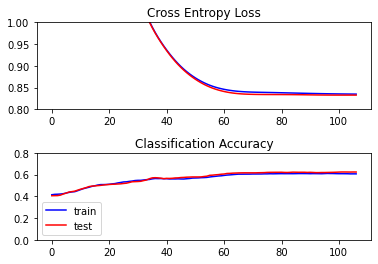

In [21]:
# plot loss as a function of epochs
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'],     color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'test')
plt.ylim(0.8,1)

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'],     color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'test')
plt.ylim(0, 0.8)
plt.legend()

# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace = 0.5)

<font color='red'>

**ANSWER Q4** <br>
...

### Q5. Compute the WtP of the average decision maker to reduce the share of foreigners in a neighbourhood by 1 percentage point using the results from the hybrid model. Compare the outcome with the results of your discrete choice model (0.5 pts)

In [22]:
# Show the trained taste parameters, from the MNL part
beta_STORES = np.squeeze((betas[0][0]))
beta_FOREIGN = np.squeeze((betas[0][1]))
print('Beta_STORES    = ', "{:.3f}".format(beta_STORES )) 
print('Beta_FOREIGN = ', "{:.3f}".format(beta_FOREIGN ))

# Compute the Willingness to Pay for a Gb extra storage space
WtP_foreign_stores_mnl = beta_FOREIGN/beta_STORES
print('Willingness-to-Pay estimates Hybrid model')
print('----------')

print('Willingness to Pay; reduction in foreigners at an expense of store distance = ', "{:.2f}".format(WtP_foreign_stores_mnl),'min per percentage point')

Beta_STORES    =  -0.045
Beta_FOREIGN =  -1.492
Willingness-to-Pay estimates Hybrid model
----------
Willingness to Pay; reduction in foreigners at an expense of store distance =  33.49 min per percentage point


In [23]:
# For comparison convert the loss to log-likelihood and rho^2
hist_loss_train = history.history.get('loss')
LL_final_train = -np.array(hist_loss_train[len(hist_loss_train)-1]) *len(Y_train)
print('Cross-entropy training data at final epoch  = ', "{:.3f}".format(hist_loss_train[len(hist_loss_train)-1]))
print('Log-likelihood training data at final epoch = ', "{:.1f}".format(LL_final_train))
print('rho square training data at final epoch     = ', "{:.2f}".format(1 - LL_final_train / -(len(Y_train)*np.log(3))))
print()

hist_loss_test = history.history.get('val_loss')
LL_final_test = -np.array(hist_loss_test[len(hist_loss_test)-1]) *len(Y_test)
print('Cross-entropy test data at final epoch     = ', "{:.3f}".format(hist_loss_test[len(hist_loss_test)-1]))
print('Log-likelihood test data at final epoch    = ', "{:.1f}".format(LL_final_test))
print('rho square test data at final epoch        = ', "{:.2f}".format(1 - LL_final_test / -(len(Y_test)*np.log(3))))


Cross-entropy training data at final epoch  =  0.835
Log-likelihood training data at final epoch =  -5240.5
rho square training data at final epoch     =  0.24

Cross-entropy test data at final epoch     =  0.833
Log-likelihood test data at final epoch    =  -2814.6
rho square test data at final epoch        =  0.24


<font color='red'>

**ANSWER Q5** <br>
...

### Q6. Explore whether, or not, the preferences of the inhabitants of the four cities regarding the trade-off between share of foreigners and distance to grocery stores are equal across the four cities. (1.5 pts)

Perform a series of (clever) analyses, and interpret the findings. In other words, can we conclude that the inhabintants of all cities are equally xenophobic? For these analysis, use hybrid models, and/or DCMs.

**Hint:** create new features capturing for the share of foreigners *per city*. 

We'll use the hybrid model because the cross entropy is the lowest. 

In [24]:
df_city1 = df[(df.SSTADT == 1)]
df_city2 = df[(df.SSTADT == 2)]
df_city3 = df[(df.SSTADT == 3)]
df_city4 = df[(df.SSTADT == 4)]
cities = [df_city1, df_city2, df_city3, df_city4]

dict_cities = {}

for count, city in enumerate(cities):
    X = city.drop(['CHOICE'], axis=1)
    Y = city['CHOICE']
    x_mnl, x_ann, Y_cat = preprocess_ANN_data(X, Y)

    # Split the data into a training and test part
    X_mnl_train, X_mnl_test, Y_train, Y_test = train_test_split(x_mnl, Y_cat, random_state = 1, test_size = 0.35)
    X_ann_train, X_ann_test, Y_train, Y_test = train_test_split(x_ann, Y_cat, random_state = 1, test_size = 0.35)
    print('\nTotal number of obervations in the data set = ', len(x_mnl))
    print('Number of obervations in the training set   = ', len(X_mnl_train))
    print('Number of obervations in the test set       = ', len(X_mnl_test))

    # Compile the model
    model = hybrid_RUM_MNL_ANN_model(NALT, no_X_MNL, no_X_ANN, num_nodes, seed=0)
    model.compile(optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"], loss = 'categorical_crossentropy')
    model.summary()

    # Train the model
    early_stopping = EarlyStopping(patience = 4, monitor = 'val_loss')
    history = model.fit([X_mnl_train, X_ann_train],Y_train, batch_size=len(X_mnl_train), epochs = nEpoch, verbose = 1, validation_data = ([X_mnl_test, X_ann_test], Y_test), callbacks = [early_stopping])

    betas_layer = model.get_layer(name = 'MNL_layer')
    betas = betas_layer.get_weights()
    print('The cross-entropy on the test data of the tensor flow ANN is',"{:.3f}".format(history.history['loss'][-1]))

    dict_cities[count] = betas
        

Shape of x_mnl (2272, 2, 3, 1)
Shape of x_ann (2272, 16)

Total number of obervations in the data set =  2272
Number of obervations in the training set   =  1476
Number of obervations in the test set       =  796
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Features2ANN (InputLayer)       [(None, 16)]         0                                            
__________________________________________________________________________________________________
ANN_layer1 (Dense)              (None, 5)            85          Features2ANN[0][0]               
__________________________________________________________________________________________________
Features2MNL (InputLayer)       [(None, 2, 3, 1)]    0                                            
_____________________________________________________________________________

In [25]:
dict_cities

{0: [array([[[[-0.03817703]]],
  
  
         [[[-1.3938229 ]]]], dtype=float32)],
 1: [array([[[[-0.03266556]]],
  
  
         [[[-1.4173497 ]]]], dtype=float32)],
 2: [array([[[[-0.04574197]]],
  
  
         [[[-1.3808821 ]]]], dtype=float32)],
 3: [array([[[[-0.04153115]]],
  
  
         [[[-1.2065728 ]]]], dtype=float32)]}

In [26]:
WTPs = {}
for count, city in enumerate(dict_cities.values()):
    # print(city)
    # Show the trained taste parameters, from the MNL part
    beta_STORES = np.squeeze((city[0][0]))
    beta_FOREIGN = np.squeeze((city[0][1]))
    print('\nBeta_STORES    = ', "{:.3f}".format(beta_STORES )) 
    print('Beta_FOREIGN = ', "{:.3f}".format(beta_FOREIGN ))

    # Compute the Willingness to Pay for a Gb extra storage space
    WtP_foreign_stores_mnl = beta_FOREIGN/beta_STORES
    print('Willingness-to-Pay estimates Hybrid model')
    print('----------')

    print('Willingness to Pay; reduction in foreigners at an expense of store distance = ', "{:.2f}".format(WtP_foreign_stores_mnl),'min per percentage point')
    WTPs[count] = WtP_foreign_stores_mnl


Beta_STORES    =  -0.038
Beta_FOREIGN =  -1.394
Willingness-to-Pay estimates Hybrid model
----------
Willingness to Pay; reduction in foreigners at an expense of store distance =  36.51 min per percentage point

Beta_STORES    =  -0.033
Beta_FOREIGN =  -1.417
Willingness-to-Pay estimates Hybrid model
----------
Willingness to Pay; reduction in foreigners at an expense of store distance =  43.39 min per percentage point

Beta_STORES    =  -0.046
Beta_FOREIGN =  -1.381
Willingness-to-Pay estimates Hybrid model
----------
Willingness to Pay; reduction in foreigners at an expense of store distance =  30.19 min per percentage point

Beta_STORES    =  -0.042
Beta_FOREIGN =  -1.207
Willingness-to-Pay estimates Hybrid model
----------
Willingness to Pay; reduction in foreigners at an expense of store distance =  29.05 min per percentage point


In [27]:
print(WTPs)

{0: 36.509464, 1: 43.389725, 2: 30.188517, 3: 29.052237}


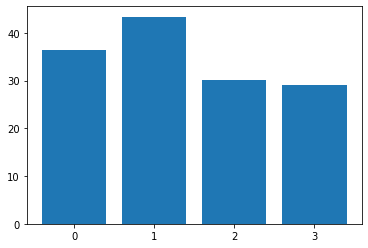

In [28]:
names = list(WTPs.keys())
values = list(WTPs.values())

plt.bar(range(len(WTPs)), values, tick_label=names)
plt.show()

In [29]:
# Using DCM. 
Wtp_stores = np.zeros((4,1))
Wtp_green =  np.zeros((4,1))
Wtp_city =  np.zeros((4,1))
Wtp_noise =  np.zeros((4,1))
Wtp_transport =  np.zeros((4,1))

for i in range(4): 
    B_stores = Beta('B_stores', 0, None, None, 0)
    B_transport = Beta('B_transport', 0, None, None, 0)
    B_city = Beta('B_city', 0, None, None, 0)
    B_noise = Beta('B_noise', 0, None, None, 0)
    B_green = Beta('B_green', 0, None, None, 0)
    B_foreign = Beta('B_foreign', 0, None, None, 0)
    
    # Create a DataFrame with pandas and database variable for Biogeme estimation
    database = db.Database('residential_choicedata2021', cities[i])
    # The following statement allows you to use the names of the variable stored in Biogeme as Python variables.
    globals().update(database.variables)

    # Utility functions
    V1 = B_stores * STORES1 + B_transport * TRANSPORT1 + B_city * CITY1 + B_noise * NOISE1 + B_green * GREEN1 + B_foreign * FOREIGN1
    V2 = B_stores * STORES2 + B_transport * TRANSPORT2 + B_city * CITY2 + B_noise * NOISE2 + B_green * GREEN2 + B_foreign * FOREIGN2
    V3 = B_stores * STORES3 + B_transport * TRANSPORT3 + B_city * CITY3 + B_noise * NOISE3 + B_green * GREEN3 + B_foreign * FOREIGN3
    # Associate utility functions with the numbering of alternatives in df.CHOICE
    V = {1: V1, 2: V2, 3: V3}

    # Associate the availability conditions with the alternatives
    av = {1:1, 2:1, 3:1}
    # Definition of the model. This is the contribution of each observation to the log likelihood function.
    prob = models.loglogit(V, av, CHOICE)

    # Create the Biogeme object
    biogeme = bio.BIOGEME(database, prob)
    biogeme.modelName = 'My first discrete choice model'
    biogeme.generatePickle = False
    biogeme.generateHtml = False

    # Calculate the null log likelihood for reporting.
    biogeme.calculateNullLoglikelihood(av)
    # Estimate the parameters
    results1 = biogeme.estimate()
    # Report the results in a pandas table
    betas1 = results1.getBetaValues()
    # different relationships 
    Wtp_stores[i] = betas1['B_foreign']/betas1['B_stores']
    Wtp_green[i] = betas1['B_foreign']/betas1['B_green']
    Wtp_transport[i] = betas1['B_foreign']/betas1['B_transport']
    Wtp_noise[i] = betas1['B_foreign']/betas1['B_noise']
    Wtp_city[i] = betas1['B_foreign']/betas1['B_city']
    print('for city {}: \n \
    B_foreign/B_stores    = {}, \n \
    B_foreign/B_green     = {}, \n \
    B_foreign/B_transport = {}, \n \
    B_foreign/B_noise     = {}, \n \
    B_foreign/B_city      = {}'.format(i, Wtp_stores[i][0], Wtp_green[i][0], Wtp_transport[i][0], Wtp_noise[i][0], Wtp_city[i][0]))

for city 0: 
     B_foreign/B_stores    = 50.57419337900384, 
     B_foreign/B_green     = -4.260348025032118, 
     B_foreign/B_transport = 29.153607982693305, 
     B_foreign/B_noise     = 3.990615506609305, 
     B_foreign/B_city      = 13.497560658243382
for city 1: 
     B_foreign/B_stores    = 91.7409889575811, 
     B_foreign/B_green     = -5.081478181204524, 
     B_foreign/B_transport = 49.267254400591646, 
     B_foreign/B_noise     = 5.524995579538477, 
     B_foreign/B_city      = 40.05729964794569
for city 2: 
     B_foreign/B_stores    = 17.22912635616378, 
     B_foreign/B_green     = -1.3736205508144612, 
     B_foreign/B_transport = 6.3257653048298845, 
     B_foreign/B_noise     = 1.2217864343582738, 
     B_foreign/B_city      = 2.2196087923025063
for city 3: 
     B_foreign/B_stores    = 12.70693055960464, 
     B_foreign/B_green     = -1.3352471519300062, 
     B_foreign/B_transport = 6.125015073606175, 
     B_foreign/B_noise     = 1.234017035690836, 
     B_forei

Willingness to pay for one percent point less of foreigners


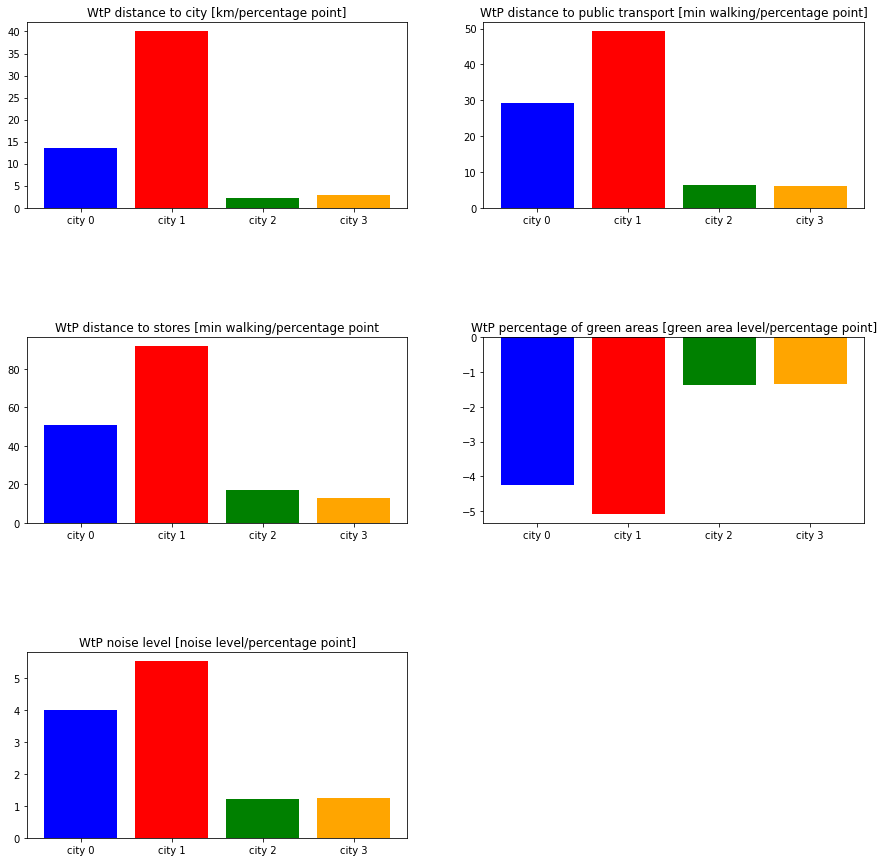

In [30]:
## create barplot for each Wtp. 
colors = ['b', 'r', 'g', 'orange']
labels = ['city 0', 'city 1', 'city 2', 'city 3']

print('Willingness to pay for one percent point less of foreigners')
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.bar(range(len(cities)), Wtp_city[:,0], color=colors, tick_label=labels)
plt.title('WtP distance to city [km/percentage point]')
plt.subplot(3,2,2)
plt.bar(range(len(cities)), Wtp_transport[:,0], color=colors, tick_label=labels)
plt.title('WtP distance to public transport [min walking/percentage point]')
plt.subplot(3,2,3)
plt.bar(range(len(cities)), Wtp_stores[:,0], color=colors, tick_label=labels)
plt.title('WtP distance to stores [min walking/percentage point')

plt.subplot(3,2,4)
plt.bar(range(len(cities)), Wtp_green[:,0], color=colors, tick_label=labels)
plt.title('WtP percentage of green areas [green area level/percentage point]')

plt.subplot(3,2,5)
plt.bar(range(len(cities)), Wtp_noise[:,0], color=colors, tick_label=labels)
plt.title('WtP noise level [noise level/percentage point]')
plt.subplots_adjust(hspace=0.7)
plt.show()


<font color='red'>

**ANSWER Q6** <br>
For the hybrid model we can only get two beta-values out each time. Therefore it is hard to say whether a city is xenophobic when comparing only the wtp for the share of foreigners compared to the walking distance to the stores. As the output might also be interpretable as people really don't mind how far away from the store they live. <br>
Using the DCM we can compare the wtp of the share of foreigners to all the other beta values to get a more complete picture of what people want. 

<br> From the barplots of the DCM model we can conclude that city 1 is the most xenophobic city, as they are willing to give in on all other aspects for a smaller percentage of foreigners in their city. After that city 0 is most xenophobic. 